In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import math
import tensorflow as tf
import tensorflow_probability as tfp

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import jacques
from jacques import kcqe
from jacovid import util

In [2]:
data = util.load_data()
data

location       date inc_hosp  population      rate
1018        AK 2020-10-01      3.0      731545  0.410091
1019        AK 2020-10-02      7.0      731545  0.956879
1020        AK 2020-10-03      5.0      731545  0.683485
1021        AK 2020-10-04      5.0      731545  0.683485
1022        AK 2020-10-05      1.0      731545  0.136697
...        ...        ...      ...         ...       ...
38946       WY 2021-06-27     10.0      578759  1.727835
38947       WY 2021-06-28      9.0      578759  1.555051
38948       WY 2021-06-29      7.0      578759  1.209484
38949       WY 2021-06-30      8.0      578759  1.382268
38950       WY 2021-07-01      3.0      578759   0.51835

[13974 rows x 5 columns]

In [24]:
def trailing_taylor_coefs_taylor_update(loc_data,
                                        target_var,
                                        taylor_degree = 1,
                                        taylor_innovations = 1,
                                        update_frequency = 1,
                                        window = 21,
                                        include_dow = True,
                                        ew_span = 14,
                                        realtime = True):
    '''
    Estimate the parameters of a Taylor polynomial fit to a rolling
    trailing window, with the coefficients in consecutive windows
    updated according to a Taylor process with noise.
    
    Parameters
    ----------
    loc_data: a pandas data frame with data for one location
    target_var: variable for which to calculate neighborhoods
    taylor_degree: degree of the Taylor polynomial
    taylor_innovations: 'all' or 'highest'
    window: window size
    ew_span: span for exponential weighting of observations.
        No weighting is done if ew_span is None.
    realtime: if True, get estimates at each time point as though in real time
    
    Returns
    -------
    Data frame with the same number of rows as the input data and columns
    `target_var + '_taylor_' + d` for each degree d in 0, 1, 2
    
    Notes
    -----
    In window t, the updated coefficients are A @ beta_{t-1}, where A is
    [ 1  1  0.5  ...  1 / D!    
      0  1  1    ...  1 / (D-1)!
      ...
      0  0  0    ...  1           ]
      
    With D = 2, this is
    
    [ 1  1  0.5 ]                [ 0 ]
    [ 0  1  1   ] @ beta_{t-1} + [ 0 ]
    [ 0  0  1   ]                [ gamma_t ]
    
    Suppose we start with a vector alpha of length taylor_degree + [T - (taylor_degree - 1)] + 6
    We can convert this to the vector of taylor coefficients by setting
    beta_1 = [I_3  0  ...  0 ] @ alpha
    
             [ 1  1  0.5 ]                [ 0  0  0  0  0 ... 0 ]
    beta_2 = [ 0  1  1   ] @ beta_{t-1} + [ 0  0  0  0  0 ... 0 ] @ alpha
             [ 0  0  1   ]                [ 0  0  0  1  0 ... 0 ]
    
             [ 1  1  0.5  0 ... 0]
           = [ 0  1  1    0 ... 0] @ alpha
             [ 0  0  1    1 ... 0]
    
             [ 1  1  0.5 ]                [ 0  0  0  0  0 ... 0 ]
    beta_3 = [ 0  1  1   ] @ beta_{t-1} + [ 0  0  0  0  0 ... 0 ] @ alpha
             [ 0  0  1   ]                [ 0  0  0  0  1 ... 0 ]
    
             [ 1  1  0.5  0  0 ... 0]
           = [ 0  1  1    0  0 ... 0] @ alpha
             [ 0  0  1    0  1 ... 0]
    
    The actual X used is the X of Taylor basis functions times the above matrix premultiplying alpha.
    '''
    loc_data = loc_data[[target_var] + ['date']]
    for l in range(window):
        loc_data[target_var + '_lag_' + str(l)] = loc_data[[target_var]].shift(l)
        loc_data['dow_lag_' + str(l)] = loc_data['date'].dt.dayofweek.shift(l)

    loc_data_nona = loc_data.dropna()
    
    if update_frequency == 7:
        loc_data_nona = loc_data_nona[loc_data_nona.dow_lag_0 == 0]

    lagged_vars = [target_var + '_lag_' + str(l) for l in range(window)]
    y = loc_data_nona[lagged_vars].values.astype('float64')
    y = y.reshape(math.prod(y.shape))
    
    lagged_dow_vars = ['dow_lag_' + str(l) for l in range(window)]
    dow = loc_data_nona[lagged_dow_vars].values
    dow = dow.reshape(math.prod(dow.shape))
    
    # basis functions for separate Taylor polynomials per window
    if taylor_degree == 1:
        one_taylor_X = np.concatenate(
            [
                np.ones((window, 1)),
                np.expand_dims(-np.arange(window), -1)
            ],
            axis = 1
        )
        taylor_shift = np.array([[1., 1.], [0., 1.]])
    elif taylor_degree == 2:
        one_taylor_X = np.concatenate(
            [
                np.ones((window, 1)),
                np.expand_dims(-np.arange(window), -1),
                np.expand_dims(+0.5 * np.arange(window)**2, -1)
            ],
            axis = 1
        )
        taylor_shift = np.array([[1., 1., 0.5], [0., 1., 1.], [0., 0., 1.]])
    elif taylor_degree == 3:
        one_taylor_X = np.concatenate(
            [
                np.ones((window, 1)),
                np.expand_dims(-np.arange(window), -1),
                np.expand_dims(+0.5 * np.arange(window)**2, -1),
                np.expand_dims(-(1. / 6.) * np.arange(window)**3, -1)
            ],
            axis = 1
        )
        taylor_shift = np.array([[1., 1., 0.5, 1/6.], [0., 1., 1., 0.5], [0., 0., 1., 1.], [0., 0., 0., 1.]])
    
    n_orig = loc_data_nona.shape[0]
    n_taylor_coef = taylor_degree + 1
    taylor_X = [
        np.concatenate(
            [
                np.zeros((window, i * n_taylor_coef)),
                one_taylor_X,
                np.zeros((window, (n_orig - i - 1) * n_taylor_coef))
            ],
            axis = 1
        ) \
            for i in range(n_orig)
    ]
    taylor_X = np.concatenate(taylor_X, axis = 0)
    # print("taylor_X")
    # print(taylor_X)
    
    # if taylor_innovations == 'highest':
    obs_i_shift = np.concatenate(
        [np.eye(n_taylor_coef), np.zeros((n_taylor_coef, (n_orig - 1) * taylor_innovations))],
        axis = 1
    )
    taylor_coef_shift = [ obs_i_shift ]
    
    for i in range(1, n_orig):
        obs_i_shift = np.matmul(taylor_shift, obs_i_shift)
        for j in range(taylor_innovations):
            obs_i_shift[n_taylor_coef - j - 1, n_taylor_coef + i * taylor_innovations - j - 1] += 1.
            # print("obs_i_shift, j = " + str(j))
            # print(obs_i_shift)
        taylor_coef_shift = taylor_coef_shift + [
            obs_i_shift
        ]
    
    taylor_coef_shift = np.concatenate(taylor_coef_shift, axis = 0)
    # elif taylor_innovations == 'all':
    #     taylor_coef_shift = np.identity(taylor_X.shape[1])

    # basis functions for day of week effects
    # we require the effects to sum to 0: \sum_{i=0}^6 gamma_i = 0.
    # then gamma_6 = - \sum_{i=0}^5 gamma_i
    # dow_X has 6 columns with indicators for day of weeks 0 through 5,
    # all values -1 in rows where day of week is 6
    dow_X = np.zeros((len(dow), 6))
    for i in range(6):
        dow_X[np.where(dow == i), i] = 1.
    
    dow_X[np.where(dow == 6), :] = -1.
    
    # combine taylor_X and dow_X
    if realtime:
        beta_hat_taylor_rows = []
        for i in range(n_orig):
            # print("taylor_X_i input")
            # print(taylor_X[:((i+1)*window), :])
            # print(taylor_coef_shift[:, :(n_taylor_coef + i * taylor_innovations)])
            taylor_X_i = np.matmul(taylor_X, taylor_coef_shift)[:((i+1)*window), :(n_taylor_coef + i * taylor_innovations)]
            # if taylor_innovations == 'highest':
            #     taylor_X_i = np.matmul(taylor_X, taylor_coef_shift)[:((i+1)*window), :(n_taylor_coef + i)]
            # else:
            #     taylor_X_i = np.matmul(taylor_X, taylor_coef_shift)[:((i+1)*window), :(n_taylor_coef * (i + 1))]
            
            if include_dow:
                X_i = np.concatenate(
                    [
                        taylor_X_i,
                        dow_X[:((i+1)*window), :]
                    ],
                    axis=1
                )
            else:
                X_i = taylor_X_i
            
            # print("unweighted X")
            # print(X_i)
            
            y_i = y[:((i+1)*window)]

            if ew_span is not None:
                # organize exponential weighted observation weights
                ew_alpha = 2 / (ew_span + 1)
                orig_obs_weights = ew_alpha * (1 - ew_alpha)**np.arange(i + window - 1, -1, -1)
                windowed_obs_weights = np.concatenate(
                    [orig_obs_weights[j:(window + j)][::-1] for j in range(i + 1)],
                    axis = 0
                )
                W = np.diag(np.sqrt(windowed_obs_weights))
                
                # update X_i and y_i to incorporate weights
                X_i = np.matmul(W, X_i)
                y_i = np.matmul(W, y_i)

            # print("X_i")
            # print(X_i)
            # print("y_i")
            # print(y_i)
            beta_hat = np.linalg.lstsq(X_i, y_i, rcond=None)[0]
            # print("beta_hat")
            # print(beta_hat)
            
            if include_dow:
                beta_hat_taylor = beta_hat[:-6]
            else:
                beta_hat_taylor = beta_hat
            
            beta_hat_taylor = np.matmul(
                taylor_coef_shift[:(n_taylor_coef * (i + 1)), :(n_taylor_coef + i * taylor_innovations)],
                beta_hat_taylor)
            # if taylor_innovations == 'highest':
                # beta_hat_taylor = np.matmul(
                #     taylor_coef_shift[:(n_taylor_coef * (i + 1)), :(n_taylor_coef + i)],
                #     beta_hat[:-6])
            # else:
            #     beta_hat_taylor = beta_hat[:-6]
            
            beta_hat_taylor = beta_hat_taylor.reshape(
                (beta_hat_taylor.shape[0] // n_taylor_coef, n_taylor_coef)
            )
            # print("beta_hat_taylor")
            # print(beta_hat_taylor)
            
            beta_hat_taylor_rows = beta_hat_taylor_rows + \
                [ beta_hat_taylor[i:(i + 1), :] ]
        
        beta_hat_taylor = np.concatenate(beta_hat_taylor_rows, axis = 0)
        # print("final beta_hat_taylor")
        # print(beta_hat_taylor)
    else:
        taylor_X = np.matmul(taylor_X, taylor_coef_shift)
        
        X = np.concatenate([taylor_X, dow_X], axis=1)
        
        beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]
        
        beta_hat_taylor = np.matmul(taylor_coef_shift, beta_hat[:-6])
        beta_hat_taylor = beta_hat_taylor.reshape(
            (beta_hat_taylor.shape[0] // n_taylor_coef, n_taylor_coef)
        )
    
    # if include_dow:
    #     beta_hat_dow = beta_hat[-6:]
    #     beta_hat_dow = np.concatenate(
    #         [beta_hat_dow, -np.sum(beta_hat_dow, keepdims=True)],
    #         axis = 0
    #     )
    # else:
    #     beta_hat_dow = []
    
    # return beta_hat, beta_hat_taylor, beta_hat_dow
    return pd.DataFrame({
        target_var + '_taylor_' + str(d): np.concatenate([np.full(window - 1, np.nan), beta_hat_taylor[:, d]], axis = 0) \
            for d in range(n_taylor_coef)
    })


In [28]:
data['fourth_rt_rate'] = data['rate'] ** 0.25

taylor_ests = data.groupby(['location']) \
    .apply(trailing_taylor_coefs_taylor_update,
           target_var='fourth_rt_rate',
           window = 21,
           ew_span = 21) \
    .reset_index() \
    .drop(['location' , 'level_1'], axis = 1)

for col_name in taylor_ests.columns:
    data[col_name] = taylor_ests[col_name].values


In [26]:
data['rate_h_14'] = data.groupby(['location']).rate.shift(-14)
data


location       date inc_hosp  population      rate fourth_rt_rate  \
1018        AK 2020-10-01      3.0      731545  0.410091        0.80024   
1019        AK 2020-10-02      7.0      731545  0.956879       0.989041   
1020        AK 2020-10-03      5.0      731545  0.683485       0.909248   
1021        AK 2020-10-04      5.0      731545  0.683485       0.909248   
1022        AK 2020-10-05      1.0      731545  0.136697       0.608051   
...        ...        ...      ...         ...       ...            ...   
38946       WY 2021-06-27     10.0      578759  1.727835       1.146504   
38947       WY 2021-06-28      9.0      578759  1.555051       1.116699   
38948       WY 2021-06-29      7.0      578759  1.209484       1.048697   
38949       WY 2021-06-30      8.0      578759  1.382268       1.084297   
38950       WY 2021-07-01      3.0      578759   0.51835       0.848508   

       fourth_rt_rate_taylor_0  fourth_rt_rate_taylor_1 rate_h_14  
1018                       NaN                      NaN  1.640364  
1019                       NaN                      NaN  1.093576  
1020                       NaN                      NaN  0.410091  
1021                       NaN                      NaN  1.093576  
1022                       NaN                      NaN  1.503667  
...                        ...                      ...       ...  
38946                 0.975829                -0.005180       NaN  
38947                 1.005189                -0.002005       NaN  
38948                 1.029449                 0.000668       NaN  
38949                 1.053626                 0.002850       NaN  
38950                 1.048542                 0.001830       NaN  

[13974 rows x 9 columns]

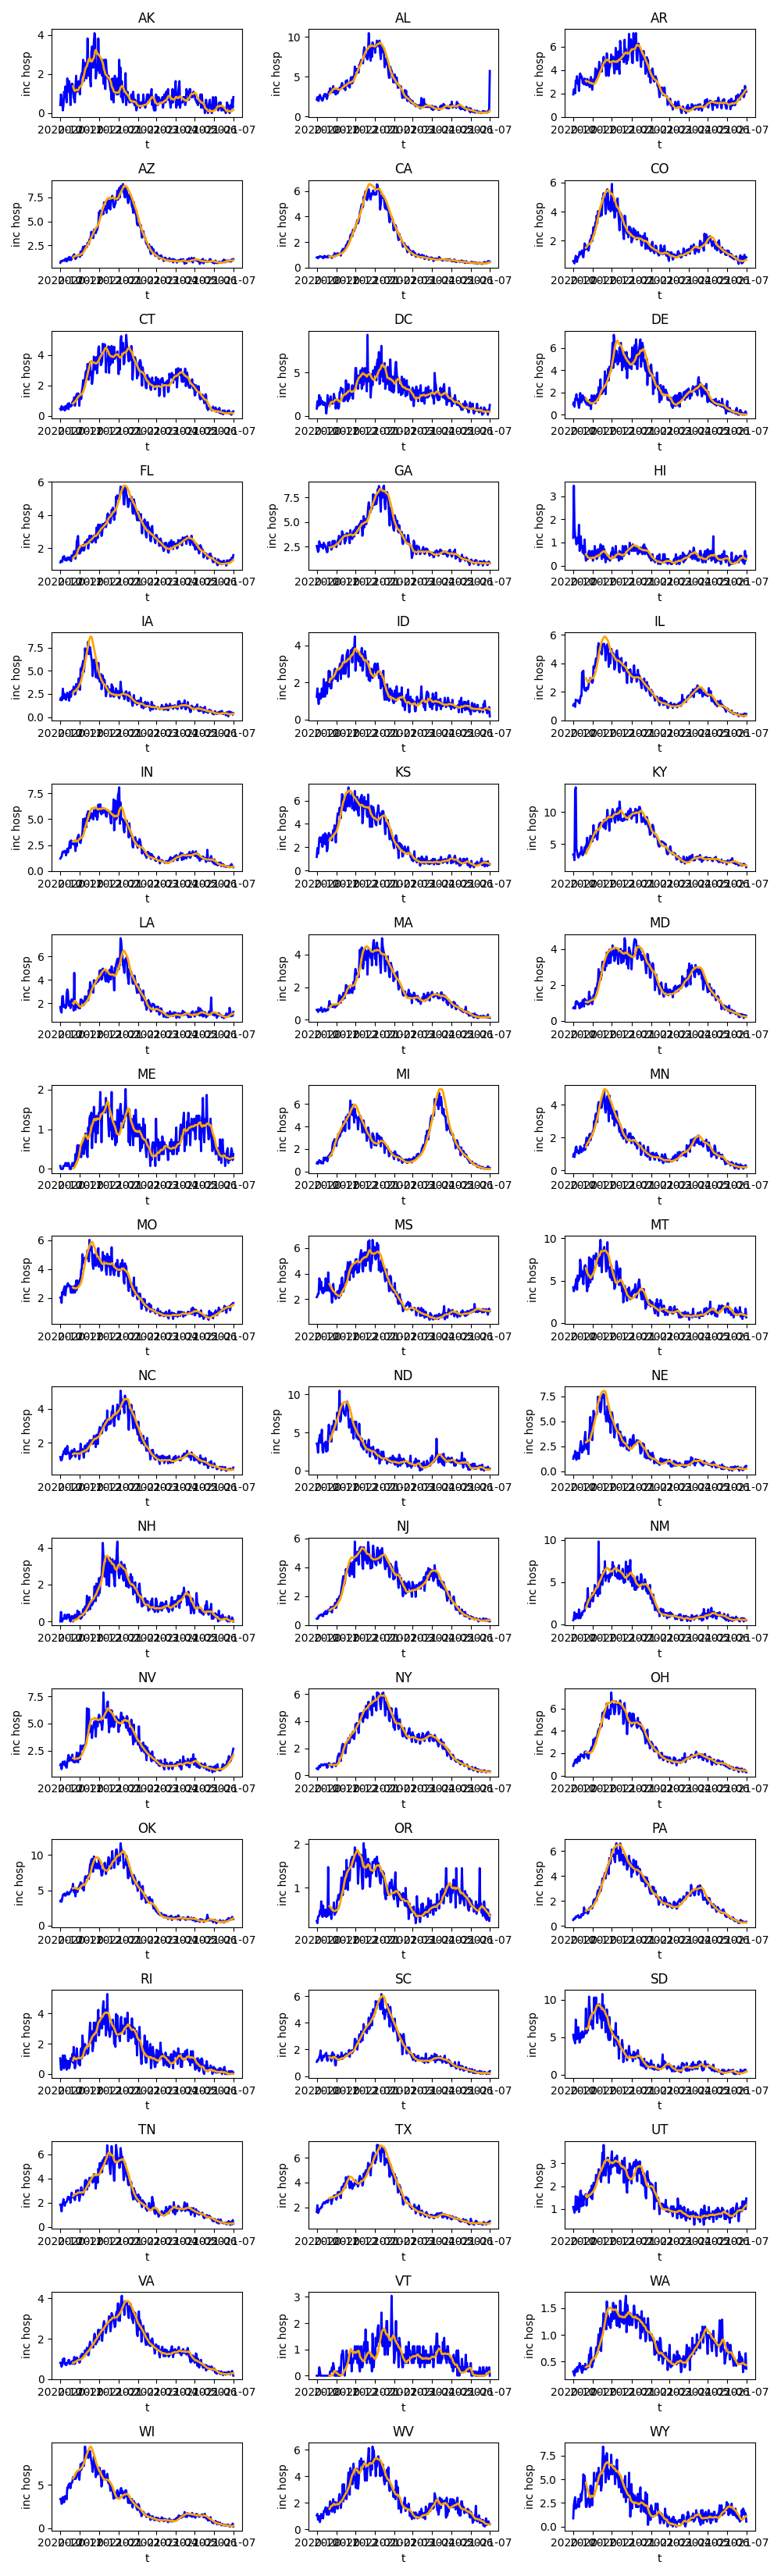

In [29]:
fig, ax = plt.subplots(17, 3, figsize=(10, 33))

for i, loc in enumerate(data.location.unique()):
    loc_data = data[data.location == loc]
    plot_row = i // 3
    plot_col = i % 3
    # ax[0].fill_between(t_pred, percentiles_orig[0, :], percentiles_orig[1, :], color='lightblue')
    ax[plot_row, plot_col].plot(loc_data.date, loc_data.rate, 'blue', ls='solid', lw=2.0)
    ax[plot_row, plot_col].plot(loc_data.date, loc_data.fourth_rt_rate_taylor_0**4, 'orange', ls='solid', lw=2.0)
    ax[plot_row, plot_col].set(xlabel="t", ylabel="inc hosp", title=loc)

plt.tight_layout()


/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_85222/2542803091.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


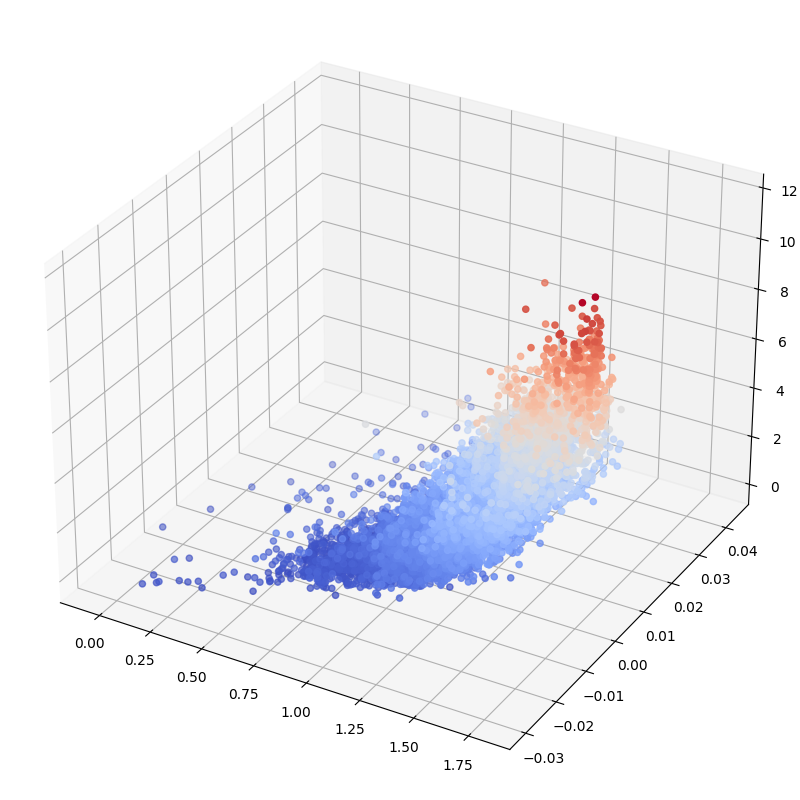

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

ax.scatter(data.dropna().fourth_rt_rate_taylor_0,
           data.dropna().fourth_rt_rate_taylor_1,
           data.dropna().rate_h_14,
           c=data.dropna().rate_h_14,
           cmap = cm.coolwarm)
plt.show()

In [31]:
x_vars = ['fourth_rt_rate_taylor_0', 'fourth_rt_rate_taylor_1']
y_var = 'rate_h_14'
data_nonas = data.dropna()

x = np.concatenate(
    [
        np.expand_dims(data_nonas[data_nonas.location == loc][x_vars].values, axis=0) \
            for loc in data_nonas.location.unique()
    ],
    axis = 0
)
x = tf.constant(x.astype('float64'))

x_test = np.concatenate(
    [
        np.expand_dims(data[(data.location == loc) & (data.date == np.max(data.date))][x_vars].values, axis=0) \
            for loc in data_nonas.location.unique()
    ],
    axis = 1
)
x_test = tf.constant(x_test.astype('float64'))

y = np.concatenate(
    [
        np.expand_dims(data_nonas[data_nonas.location == loc][y_var].values, axis=[0, -1]) \
            for loc in data_nonas.location.unique()
    ],
    axis = 0
)
y = tf.constant(y.astype('float64'))

In [32]:
x_test.shape

TensorShape([1, 51, 2])

In [33]:
kcqe_obj = kcqe.KCQE(p=2)
generator = kcqe_obj.generator(x, y, batch_size = 1, block_size = 21)

In [34]:
x_val, x_train, y_val, y_train = next(generator)
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(1, 1071, 2)
(1, 1071)
(1, 9027, 2)
(1, 9027)


In [35]:
block_size = 21
num_blocks = math.floor(y.shape[1]/block_size)

In [36]:
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    x_test = x_test, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9])),
    optim_method="adam", 
    num_epochs=50, 
    learning_rate=0.1,
    init_param_vec=tf.constant(np.array([3.0, 3.0, 1.0])),
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[3.09999365 3.09026549 0.90019078]
loss = 
0.22410613883665378
grads = 
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-4.98100251e-02, -2.93231368e-05,  1.65436022e-03])>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[3.20007432 3.17639123 0.92895595]
loss = 
0.5783214168152374
grads = 
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-0.05897054, -0.00011807, -0.00272093])>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[3.29185582 3.25149551 0.95369151]
loss = 
0.16717043642475216
grads = 
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-2.17220145e-02, -1.82613339e-05, -1.25626772e-04])>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[3.37870822 3.31456124 0.97168685]
loss = 
0.1591705193479238
grads = 
[<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.96282145e-02, -3.4040

In [37]:
q_hat = kcqe_obj.predict(param_vec,
                         x_train=tf.reshape(x, (1, np.math.prod(x.shape.as_list()[:-1]), 2)),
                         y_train=tf.reshape(y, (1, np.math.prod(y.shape.as_list()[:-1]))),
                         x_test=x_test,
                         tau=tf.constant(np.array([0.025, 0.5, 0.975])))
q_hat

<tf.Tensor: shape=(1, 51, 3), dtype=float64, numpy=
array([[[0.00000000e+00, 2.52891915e-01, 1.02443764e+00],
        [2.37249752e-01, 8.14064396e-01, 1.98828274e+00],
        [9.08750469e-01, 2.32217703e+00, 5.32404676e+00],
        [3.13574685e-01, 9.47042826e-01, 2.33479754e+00],
        [1.04606943e-01, 5.11329389e-01, 1.43939283e+00],
        [2.12762924e-01, 7.61251812e-01, 1.85813869e+00],
        [0.00000000e+00, 2.76988361e-01, 1.02306936e+00],
        [1.28144502e-01, 5.66933799e-01, 1.52600190e+00],
        [0.00000000e+00, 3.73802217e-01, 1.00011975e+00],
        [4.31648131e-01, 1.15931526e+00, 3.09958817e+00],
        [2.54670444e-01, 8.40475257e-01, 2.03074204e+00],
        [2.76137852e-02, 3.64938342e-01, 1.16045375e+00],
        [6.86426380e-02, 4.27682035e-01, 1.29556001e+00],
        [1.43202208e-01, 6.06419028e-01, 1.58495028e+00],
        [5.19133885e-02, 3.93262378e-01, 1.22469493e+00],
        [9.80332866e-02, 4.83962673e-01, 1.39823524e+00],
        [1.61137071e

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_85222/3137045033.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


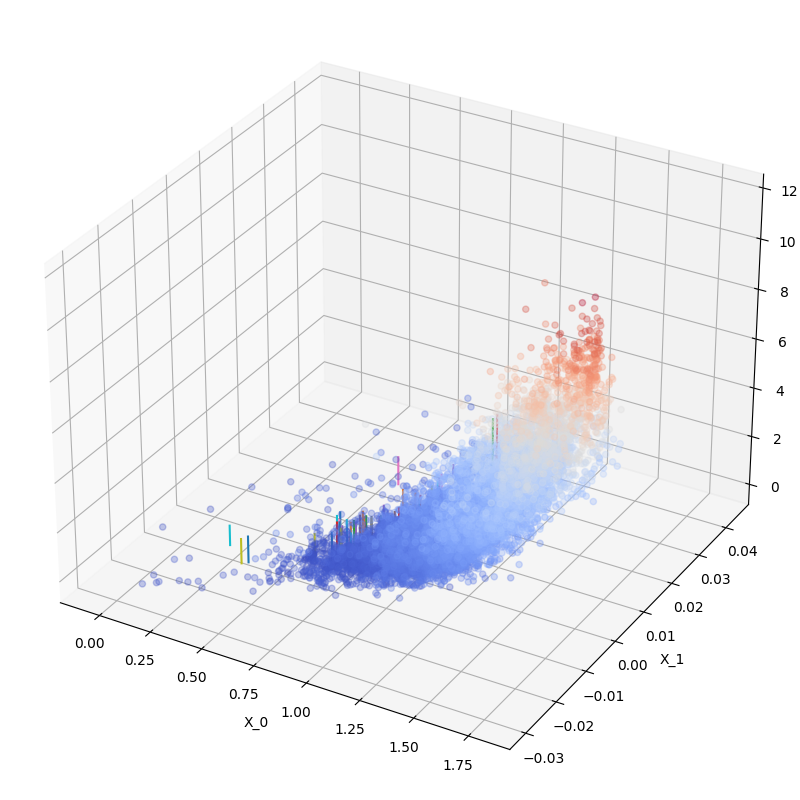

In [38]:
fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

ax.scatter(data.dropna().fourth_rt_rate_taylor_0,
           data.dropna().fourth_rt_rate_taylor_1,
           data.dropna().rate_h_14,
           c=data.dropna().rate_h_14,
           cmap = cm.coolwarm,
           alpha = 0.3)


for loc_ind in range(x_test.shape[1]):
    loc_x_test = x_test[0, loc_ind, :].numpy()
    plt.plot(
        np.full(2, loc_x_test[0]),
        np.full(2, loc_x_test[1]),
        q_hat.numpy()[(0, loc_ind, np.array([0, 2]))]
    )
# ax.lines(np.full(2, loc_x_test[0]),
#          np.full(2, loc_x_test[1]),
#          q_hat.numpy()[(0, 0, np.array([0, 2]))])

# x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
# x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
# q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
# q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
# q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

# ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
# ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
# ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()

In [40]:
state_info = pd.read_csv("data/locations.csv")

quantiles = [0.025, 0.5, 0.975]

predictions = pd.concat(
    [
        pd.DataFrame({
            'location': data_nonas.location.unique(),
            'quantile': q_level,
            'value': q_hat[0, :, i]
        }) \
            for i, q_level in enumerate(quantiles)
    ],
    axis = 0)

# merge in population column
predictions = predictions.merge(state_info[['abbreviation','location','population']],
                                left_on="location",
                                right_on="abbreviation",
                                how = "left")

# clean up detritus from merging
predictions = predictions[['abbreviation', 'location_y', 'quantile', 'value', 'population']]
predictions.columns = ['abbreviation', 'location', 'quantile', 'value', 'population']

# update predictions to original units rather than rates per 100k population
predictions['pop100k'] = predictions.population / 100000
predictions['value'] = predictions.value * predictions.pop100k
   
predictions

abbreviation location  quantile       value  population    pop100k
0             AK       02     0.025    0.000000      731545    7.31545
1             AL       01     0.025   11.632794     4903185   49.03185
2             AR       05     0.025   27.424308     3017804   30.17804
3             AZ       04     0.025   22.824214     7278717   72.78717
4             CA       06     0.025   41.332529    39512223  395.12223
..           ...      ...       ...         ...         ...        ...
148           VT       50     0.975    7.069146      623989    6.23989
149           WA       53     0.975  109.774996     7614893   76.14893
150           WI       55     0.975   63.481687     5822434   58.22434
151           WV       54     0.975   23.846492     1792147   17.92147
152           WY       56     0.975   14.762743      578759    5.78759

[153 rows x 6 columns]

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_85222/212188844.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_pred['date'] = last_obs_date + pd.Timedelta(14, 'days')
/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_85222/212188844.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_pred['date'] = last_obs_date + pd.Timedelta(14, 'days')
/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_85222/212188844.py:7: SettingWithCopyWarning: 
A value is trying to be set on a

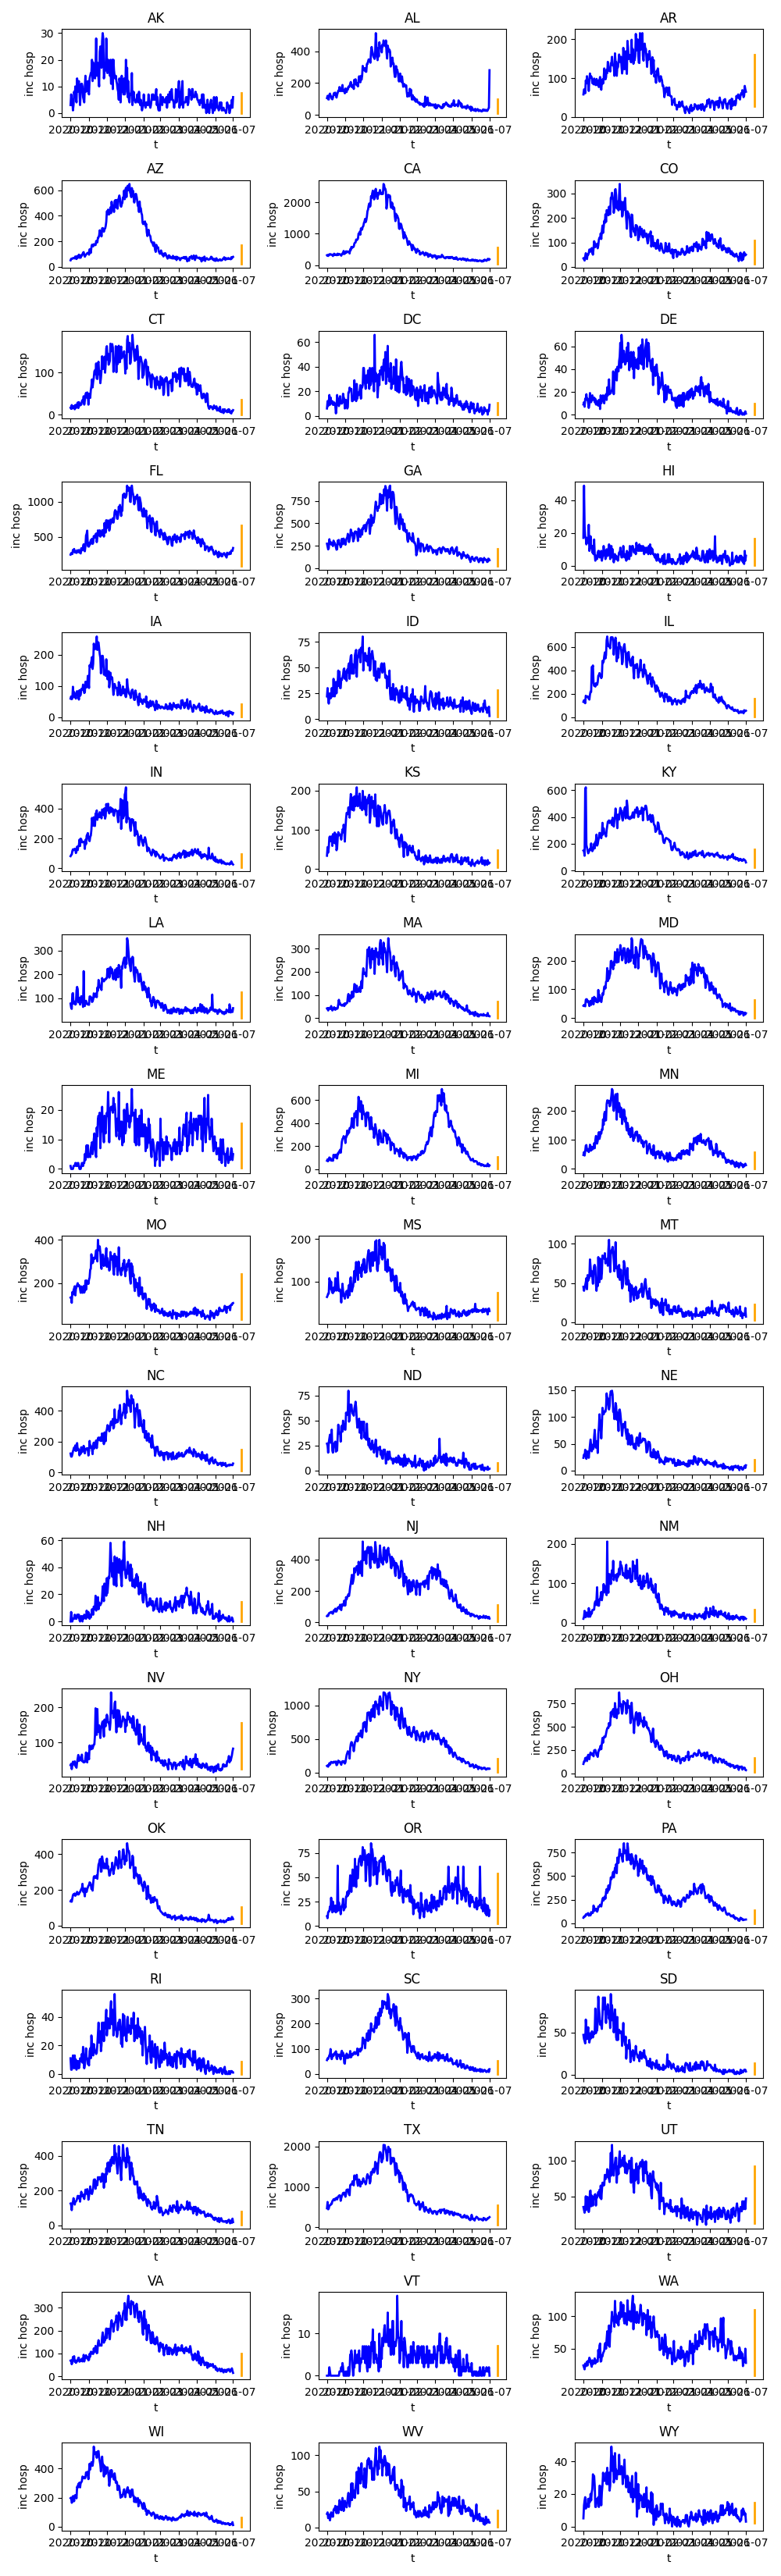

In [41]:
fig, ax = plt.subplots(17, 3, figsize=(10, 33))

for i, loc in enumerate(data.location.unique()):
    loc_data = data[data.location == loc]
    last_obs_date = np.max(loc_data.date)
    loc_pred = predictions[predictions.abbreviation == loc]
    loc_pred['date'] = last_obs_date + pd.Timedelta(14, 'days')
    plot_row = i // 3
    plot_col = i % 3
    # ax[0].fill_between(t_pred, percentiles_orig[0, :], percentiles_orig[1, :], color='lightblue')
    ax[plot_row, plot_col].plot(loc_data.date, loc_data.inc_hosp, 'blue', ls='solid', lw=2.0)
    ax[plot_row, plot_col].plot(loc_pred.date, loc_pred.value, 'orange', ls='solid', lw=2.0)
    # ax[0].plot(t, self.y_orig, 'black', ls='solid')
    ax[plot_row, plot_col].set(xlabel="t", ylabel="inc hosp", title=loc)

plt.tight_layout()
